## Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .
3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.
4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 
5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.


In [1]:
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

from datetime import timedelta

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV


In [3]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

# сделаем примеры и модель 
def split_data( data, koeff = None, test_count = None ):
    if koeff is None and test_count is None:
        raise ValueError(f'the separator is not filled')
    elif (koeff is not None):
        last_train_date = data.index.min() + timedelta(7*int(data.shape[0]*(1-koeff)))
    else:
        last_train_date = data.index.max() - timedelta(7*test_count)

    return data.loc[data.index <= last_train_date].copy(), \
           data.loc[data.index >  last_train_date].copy(), \
           last_train_date

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

###### **1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.**

In [4]:
data = pd.read_csv('my_PJME_MW.csv',  parse_dates = {'Date Time' : [0, 1]} )
data = data.set_index('Date Time')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145374 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 12 columns):
PJME_MW            145374 non-null float64
year               145374 non-null int64
month              145374 non-null int64
dayofmonth         145374 non-null int64
quarter            145374 non-null int64
dayofyear          145374 non-null int64
weekofyear         145374 non-null int64
dayofweek          145374 non-null int64
hour               145374 non-null int64
is_holiday         145374 non-null int64
is_prev_holiday    145374 non-null int64
is_next_holiday    145374 non-null int64
dtypes: float64(1), int64(11)
memory usage: 14.4 MB


In [5]:
data_w = data.resample('w').mean()

Удаляем признаки, относящиеся к дням

In [6]:
data_w = data_w.drop(columns=['dayofmonth','dayofyear', 'dayofweek', 'hour', 'is_holiday', 'is_prev_holiday', 'is_next_holiday'])
data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 5 columns):
PJME_MW       866 non-null float64
year          866 non-null float64
month         866 non-null float64
quarter       866 non-null float64
weekofyear    866 non-null float64
dtypes: float64(5)
memory usage: 40.6 KB


In [7]:
def add_features(df, p):
    #добавляем первую разность
    first_diff =np.array(df.iloc[1:,0].values - df.iloc[:-1,0].values).astype('float32') 
    df['diff1'] = 0
    df['diff1'] =  df['diff1'].astype('float') 
    df['diff1'].values[1:] = first_diff
  
    #добавляем логариф признака
    first_diff_l =np.log(df.iloc[1:,0].values) 
    df['diff1_l'] = 0
    df['diff1_l'] =  df['diff1_l'].astype('float') 
    df['diff1_l'].values[1:] = first_diff_l
 
    df['exp_0_01'] = exponential_smoothing(df['PJME_MW'], 0.01)
    df['exp_0_03'] = exponential_smoothing(df['PJME_MW'], 0.03)
    df['exp_0_04'] = exponential_smoothing(df['PJME_MW'], 0.04)
    df['exp_0_06'] = exponential_smoothing(df['PJME_MW'], 0.06)
    df['exp_0_07'] = exponential_smoothing(df['PJME_MW'], 0.07)
    df['exp_0_08'] = exponential_smoothing(df['PJME_MW'], 0.08)
    df['d_w4']= df['PJME_MW'].rolling(window=4).mean()
    df['d_w26']= df['PJME_MW'].rolling(window=26).mean()
    df['d_w4'].fillna(0, inplace=True)
    df['d_w26'].fillna(0, inplace=True)

    for i in range(p):
        df['t'+str(p-i)]=0
        df['t'+str(p-i)].values[p:] = df['PJME_MW'].values[i:-(p)+i]
        df['d'+str(p-i)]=0
        df['d'+str(p-i)].values[p:] = df['diff1'].values[i:-(p)+i]
    return df

p = 7
data_w = add_features(data_w, p)
data_w.tail()
#p = 0


,PJME_MW,year,month,quarter,weekofyear,diff1,diff1_l,exp_0_01,exp_0_03,exp_0_04,...,t5,d5,t4,d4,t3,d3,t2,d2,t1,d1
Date Time,,,,,,,,,,,,,,,,,,,,,
2018-07-08,38459.982143,2018.0,7.000000,3.0,27.0,2548.142822,10.557374,31149.351351,30974.370915,30993.168173,...,30945,563,28615,-2330,30316,1701,34711,4394,35911,1200
2018-07-15,36420.035714,2018.0,7.000000,3.0,28.0,-2039.946411,10.502874,31202.058195,31137.740859,31210.242874,...,28615,-2330,30316,1701,34711,4394,35911,1200,38459,2548
2018-07-22,35612.095238,2018.0,7.000000,3.0,29.0,-807.940491,10.480441,31246.158565,31271.971490,31386.316969,...,30316,1701,34711,4394,35911,1200,38459,2548,36420,-2039
2018-07-29,36581.821429,2018.0,7.000000,3.0,30.0,969.726196,10.507307,31299.515194,31431.266988,31594.137147,...,34711,4394,35911,1200,38459,2548,36420,-2039,35612,-807
2018-08-05,36568.804124,2018.0,7.505155,3.0,31.0,-13.017304,10.506951,31352.208083,31585.393102,31793.123826,...,35911,1200,38459,2548,36420,-2039,35612,-807,36581,969


In [8]:
data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 866 entries, 2002-01-06 to 2018-08-05
Freq: W-SUN
Data columns (total 29 columns):
PJME_MW       866 non-null float64
year          866 non-null float64
month         866 non-null float64
quarter       866 non-null float64
weekofyear    866 non-null float64
diff1         866 non-null float64
diff1_l       866 non-null float64
exp_0_01      866 non-null float64
exp_0_03      866 non-null float64
exp_0_04      866 non-null float64
exp_0_06      866 non-null float64
exp_0_07      866 non-null float64
exp_0_08      866 non-null float64
d_w4          866 non-null float64
d_w26         866 non-null float64
t7            866 non-null int64
d7            866 non-null int64
t6            866 non-null int64
d6            866 non-null int64
t5            866 non-null int64
d5            866 non-null int64
t4            866 non-null int64
d4            866 non-null int64
t3            866 non-null int64
d3            866 non-null int64
t2       

In [9]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.ensemble import GradientBoostingRegressor

def find_best_features(df, h,  p, count_feats=5):
    scl_target=StandardScaler()
    scl_x=StandardScaler()
    target = df['PJME_MW'].values[h+p:].reshape((df.shape[0]-h-p,1))
    y = scl_target.fit_transform(target)
    

    X = df.iloc[p:-h,:].values
    X = scl_x.fit_transform(X.astype('float64'))

    sfk =SelectKBest(f_regression, k=count_feats)
    X_new1 = sfk.fit_transform(X, y.ravel())
    print(f'SelectKBest:{df.columns[sfk.get_support()]}')

    sfp=SelectPercentile(f_regression, percentile=20)
    X_new2 = sfp.fit_transform(X, y.ravel())
    print(f'SelectPercentile20:{df.columns[sfp.get_support()]}')
          
    gr_model = GradientBoostingRegressor().fit(X, y.ravel())
    sfm = SelectFromModel(gr_model,  max_features = 5)

    sfm.fit(X, y.ravel())
    X_new3 = sfm.transform(X)
    print(f'SelectFromModel:{df.columns[sfm.get_support()]}')
    list_param_k =np.where(sfk.get_support())[0]
    list_param_p =np.where(sfp.get_support())[0]
    list_param_m =np.where(sfm.get_support())[0]

    print('Номера признаков k лучших признаков : ',list_param_k)
    print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
    print('Номера признаков для выбора по модели : ',list_param_m)
    

###### **2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .**

In [10]:
h = 4
find_best_features(data_w.copy(),h, p, 5)

SelectKBest:Index(['PJME_MW', 'diff1_l', 't7', 't6', 't1'], dtype='object')
SelectPercentile20:Index(['PJME_MW', 'diff1_l', 't7', 't6', 't5', 't1'], dtype='object')
SelectFromModel:Index(['PJME_MW', 'month', 'weekofyear', 'diff1_l', 't7'], dtype='object')
Номера признаков k лучших признаков :  [ 0  6 15 17 27]
Номера признаков лучших признаков по процентной форме:  [ 0  6 15 17 19 27]
Номера признаков для выбора по модели :  [ 0  2  4  6 15]


In [11]:
FEATS = ['PJME_MW', 'month', 'weekofyear', 'diff1_l', 't7', 't6', 't1']

In [12]:
scl_target4 =StandardScaler()
scl_x4 =StandardScaler()

train, test, days_delta = split_data(data_w[FEATS], test_count=100+h+p)
X = scl_x4.fit_transform(data_w[FEATS].iloc[p:-h,:].astype('float64'))
y = scl_target4.fit_transform(data_w['PJME_MW'].values[h+p:].reshape((data_w['PJME_MW'].shape[0]-h-p,1)))
X_train_4 = X[:train.shape[0],:]
y_train_4 = y[:train.shape[0],0]
X_test_4 =  X[train.shape[0]:,:]
y_test_4 =  y[train.shape[0]:,0]
X_train_4.shape, y_train_4.shape, X_test_4.shape, y_test_4.shape

((755, 7), (755,), (100, 7), (100,))

In [13]:
def get_random_search(X_train, y_train):
    param_dist = {"max_depth": range(1, 8, 1), 
                "n_estimators":range(100, 800, 100)}

    #  randomized search
    n_iter_search = 10

    model_gr =GradientBoostingRegressor()

    random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

    random_search.fit(X_train, y_train)

    report(random_search.cv_results_)
    return random_search

random_search = get_random_search(X_train_4, y_train_4)

Model with rank: 1
Mean validation score: 0.610 (std: 0.055)
Parameters: {'n_estimators': 300, 'max_depth': 1}

Model with rank: 2
Mean validation score: 0.597 (std: 0.057)
Parameters: {'n_estimators': 200, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.591 (std: 0.103)
Parameters: {'n_estimators': 300, 'max_depth': 3}



In [14]:
model4_g_best = GradientBoostingRegressor(max_depth=random_search.best_params_['max_depth'],  n_estimators=random_search.best_params_['n_estimators'])
model4_g_best.fit( X_train_4, y_train_4 ) 
y_test_4_pred_g = model4_g_best.predict(X_test_4)
er_g = mean_absolute_percentage_error(y_true=scl_target4.inverse_transform( y_test_4), y_pred = scl_target4.inverse_transform( y_test_4_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.760433668147954 %


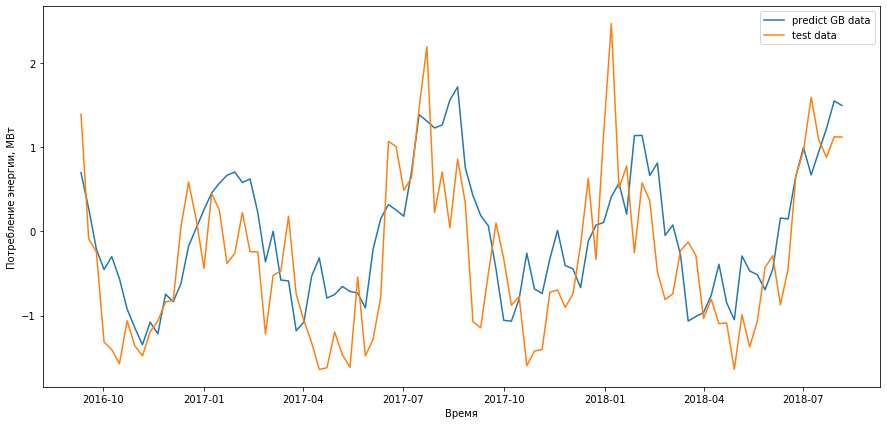

In [15]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_4_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test_4, label='test data')

plt.legend()
plt.show()

###### **3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.**

In [16]:
h = 1
find_best_features(data_w.copy(), h, p, 5)

SelectKBest:Index(['PJME_MW', 'diff1_l', 'd_w4', 't2', 't1'], dtype='object')
SelectPercentile20:Index(['PJME_MW', 'diff1_l', 'd_w4', 't3', 't2', 't1'], dtype='object')
SelectFromModel:Index(['PJME_MW', 'diff1_l', 'd_w4', 't7'], dtype='object')
Номера признаков k лучших признаков :  [ 0  6 13 25 27]
Номера признаков лучших признаков по процентной форме:  [ 0  6 13 23 25 27]
Номера признаков для выбора по модели :  [ 0  6 13 15]


In [17]:
FEATS = ['PJME_MW', 'diff1_l', 'd_w4',  't1', 't2', 't3', 't7']# 

In [18]:
train, test, days_delta = split_data(data_w[FEATS], test_count=100+h+p)
scl_target=StandardScaler()
scl_x=StandardScaler()
X = scl_x.fit_transform(data_w[FEATS].iloc[p:-h,:].astype('float64'))
y = scl_target.fit_transform(data_w['PJME_MW'].values[h+p:].reshape((data_w['PJME_MW'].shape[0]-h-p,1)))
X_train_1 = X[:train.shape[0],:]
y_train_1 = y[:train.shape[0],0]
X_test_1 =  X[train.shape[0]:,:]
y_test_1 =  y[train.shape[0]:,0]
X_train_1.shape, y_train_1.shape, X_test_1.shape, y_test_1.shape

((758, 7), (758,), (100, 7), (100,))

In [19]:
random_search = get_random_search(X_train_1, y_train_1)

Model with rank: 1
Mean validation score: 0.669 (std: 0.040)
Parameters: {'n_estimators': 100, 'max_depth': 2}

Model with rank: 2
Mean validation score: 0.668 (std: 0.041)
Parameters: {'n_estimators': 200, 'max_depth': 1}

Model with rank: 3
Mean validation score: 0.660 (std: 0.044)
Parameters: {'n_estimators': 500, 'max_depth': 1}



In [20]:
model1_g_best = GradientBoostingRegressor(max_depth=random_search.best_params_['max_depth'],  n_estimators=random_search.best_params_['n_estimators'])
model1_g_best.fit( X_train_1, y_train_1 ) 
y_test_1_pred_g = model1_g_best.predict(X_test_1)
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test_1), y_pred = scl_target.inverse_transform( y_test_1_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   6.532027087927415 %


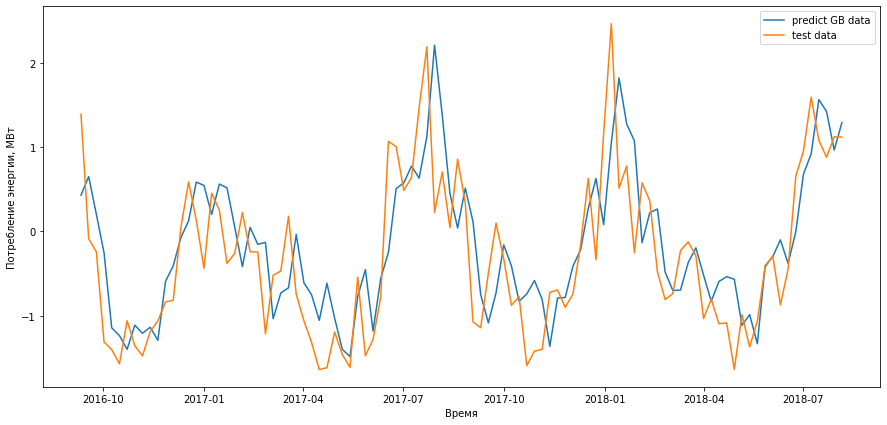

In [21]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[h+p:],y_test_1_pred_g, label='predict GB data' )
plt.plot(test.index[h+p:],y_test_1, label='test data')

plt.legend()
plt.show()

######  **4.Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.**

In [22]:
FEATS

['PJME_MW', 'diff1_l', 'd_w4', 't1', 't2', 't3', 't7']

In [23]:
X_test_100 = X_test_1.copy()
y_test_100 = y_test_1_pred_g.copy()

N10=4
for i in range(N10+1):
    y_test_100[i] = model1_g_best.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
      # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1])
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
    #строим 'd_w4' - признак под номером 2
    if i>=4:
        X_test_100[i+1,2] = np.mean(X_test_100[i-4+1:i,0])   
    if i>=1:
        X_test_100[i+1,3] = X_test_100[i-1+1,0]     
    if i>=2:
        X_test_100[i+1,4] = X_test_100[i-2+1,0]  
    if i>=3:
        X_test_100[i+1,5] = X_test_100[i-3+1,0]  
    if i>=7:
        X_test_100[i+1,6] = X_test_100[i-7+1,0]   
    X_test_100[i+1,1] = (np.log((y_i))-scl_x.mean_[6])*scl_x.scale_[6]



In [24]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test_1[:N10]),y_pred = scl_target.inverse_transform( y_test_100[:N10]))
print('ошибка градиентного бустинга MAPE c :  ', er_g,'%')

ошибка градиентного бустинга MAPE c :   5.605132930974412 %


In [25]:
er_g = mean_absolute_percentage_error(y_true=scl_target4.inverse_transform( y_test_4[:N10]), y_pred = scl_target4.inverse_transform( y_test_4_pred_g[:N10]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   6.27392833674133 %


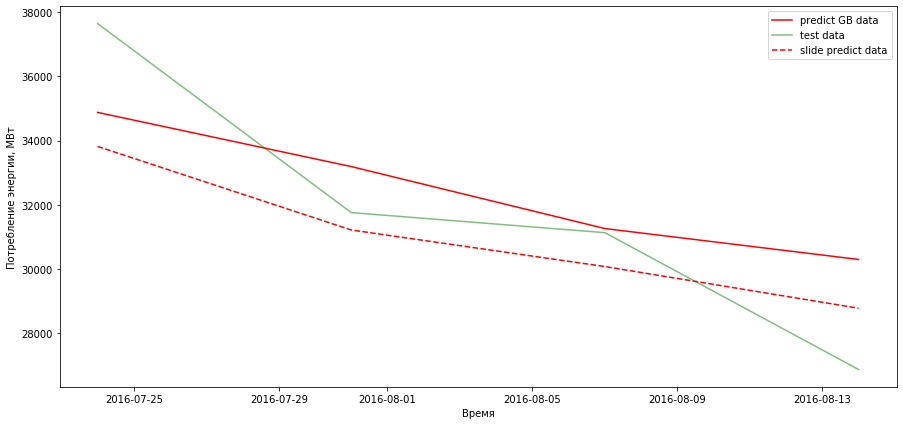

In [26]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],scl_target4.inverse_transform(y_test_4_pred_g[:N10]), 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],scl_target.inverse_transform(y_test_1[:N10]), 'g',label='test data', alpha=0.5)
plt.plot(test.index[1:N10+1],scl_target.inverse_transform(y_test_100[:N10]), '--r',label='slide predict data')

plt.legend()
plt.show()  

Результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек отличаются незначительно. 

######  **5.Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)**

In [27]:
X_test_100 = X_test_1.copy()
y_test_100 = y_test_1_pred_g.copy()

arr_er_g = {'Интервал':[],'НИТ':[]}
N10=100
for i in range(N10):
    y_test_100[i] = model1_g_best.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1])
    if i < y_test_100.shape[0]-1:
        # заполняем вектор для прогноза следующей точки
        X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
        #строим 'd_w4' - признак под номером 2
        if i>=4:
            X_test_100[i+1,2] = np.mean(X_test_100[i-4+1:i,0])   
        if i>=1:
            X_test_100[i+1,3] = X_test_100[i-1+1,0]     
        if i>=2:
            X_test_100[i+1,4] = X_test_100[i-2+1,0]  
        if i>=3:
            X_test_100[i+1,5] = X_test_100[i-3+1,0]  
        if i>=7:
            X_test_100[i+1,6] = X_test_100[i-7+1,0]   
        X_test_100[i+1,1] = (np.log((y_i))-scl_x.mean_[6])*scl_x.scale_[6]
    if i % 10 == 9:
        er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test_1[i-9:i]),y_pred = scl_target.inverse_transform( y_test_100[i-9:i]))
        arr_er_g['Интервал'].append(er_g)
        er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform(y_test_1[:i]),y_pred = scl_target.inverse_transform( y_test_100[:i]))
        arr_er_g['НИТ'].append(er_g)


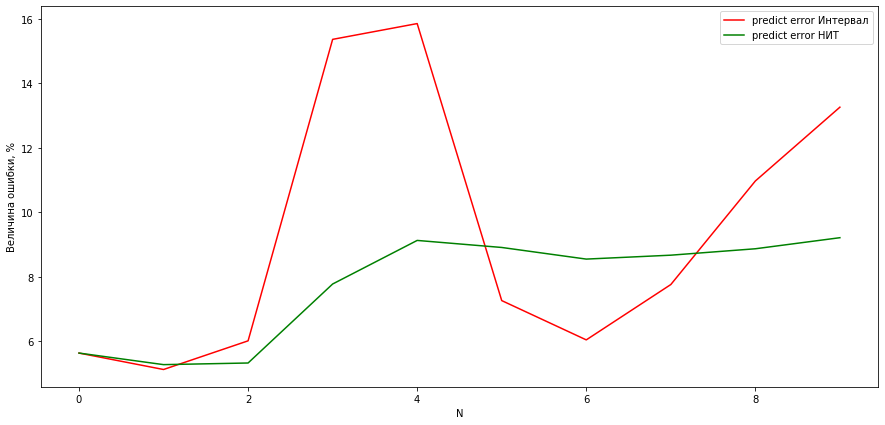

In [28]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('N')
plt.ylabel('Величина ошибки, %')
i = range(len(arr_er_g['Интервал']))
plt.plot(i ,arr_er_g['Интервал'], 'r',label='predict error Интервал' )
plt.plot(i ,arr_er_g['НИТ'], 'g',label='predict error НИТ' )
plt.legend()
plt.show()

######  **6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.**

Ошибка при увеличении горизонта прогноза возрастает. При этом наблюдаются скачки - резкое увеличение значения относительной ошибки. Вероятно, именно период на отрезке с 20 по 50 хуже всего объясняется полученной моделью.